In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from higherorder.structures.structures import Grid, Graph, Structure
from higherorder.dynamics.model import Model
from higherorder.analysis.info_measures import *
from higherorder.analysis.calculations import *
from higherorder.analysis.plots import *
from higherorder.dynamics.rules import *
from higherorder.dynamics.impacts import *
from higherorder.utils import *

# TODO remove images from notebook, just save them in the folder

Load randomly initialized grids

In [2]:
grids_dicts1 = load_init_grid_dicts(".\\data\\oneblob_grids.json", listify=True)
grids_dicts2 = load_init_grid_dicts(".\\data\\twoblob_grids.json", listify=True)
grids_dicts3 = load_init_grid_dicts(".\\data\\two_from_oneblob.json", listify=True)

Cast back to grid

In [3]:
height = 20
width = 20

grids1 = []
for i in range(len(grids_dicts1)):
    grids1.append(Grid(grids_dicts1[i], width=width, height=height))

grids3 = []
for i in range(len(grids_dicts3)):
    grids3.append(Grid(grids_dicts3[i], width=width, height=height))

This takes considerably longer to load than the other two sources (19000 grids vs 2x2400 grids)

In [ ]:
grids2 = []
for i in range(len(grids_dicts2)):
    grids2.append(Grid(grids_dicts2[i], width=width, height=height))

Run Game of Life simulation till repeating structure - better would be till repeating blobs (but also consider e.g. non stop till blobs "have a chance to meet" e.g. go in the same direction)

In [4]:
states1 = []
impact1 = []
has_died1 = []
for i in range(len(grids1)):
    sim = Model(grids1[i], dynamics_func=game_of_life,)
    sim.has_ended = False
    sim.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)
    states1.append(sim.structure.get_entities_states())
    impact1.append(sim.impact)
    has_died1.append(sim.has_ended)

In [ ]:
names = [name for impact in impact1 for v in impact.values() for name in v.values()]
names1 = [name for name in names if name == 'birth']
names2 = [name for name in names if name == 'no_birth']
names3 = [name for name in names if name == 'live']
names4 = [name for name in names if name == 'kill']
names5 = [name for name in names if name == 'redundancy_kill']
names6 = [name for name in names if name == 'redundancy_live']

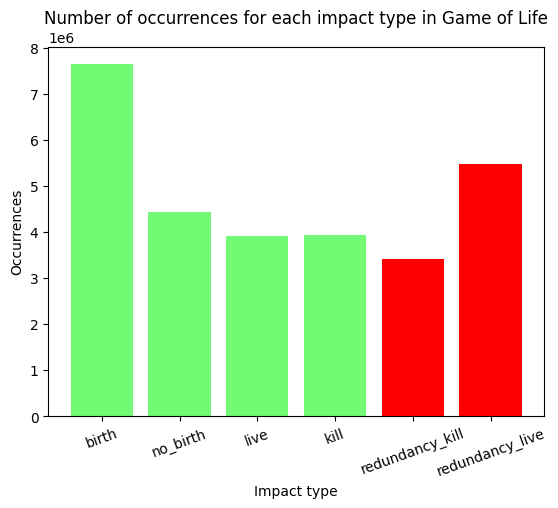

In [ ]:
fig, ax = plt.subplots()
bar_colors = ['#73fa75'] * 4 + ['#ff0000'] * 2
ax.bar(
    [1, 2, 3, 4, 5, 6],
    [len(names1), len(names2), len(names3), len(names4), len(names5), len(names6)],
    tick_label=['birth', 'no_birth', 'live', 'kill', 'redundancy_kill', 'redundancy_live'],
    color=bar_colors
)
ax.set_ylabel('Occurrences')
ax.set_xlabel('Impact type')
ax.set_title('Number of occurrences for each impact type in Game of Life')
plt.xticks(rotation=20)
plt.show()

In [ ]:
states3 = []
impact3 = []
has_died3 = []
for i in range(len(grids3)):
    sim = Model(grids3[i], dynamics_func=game_of_life,)
    sim.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)
    states3.append(sim.structure.get_entities_states())
    impact3.append(sim.impact)
    has_died3.append(sim.has_ended)

In [ ]:
states2 = []
impact2 = []
for i in range(len(grids2)):
    sim = Model(grids2[i], dynamics_func=game_of_life,)
    sim.has_ended = False
    sim.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)
    states2.append(sim.structure.get_entities_states())
    impact2.append(sim.impact)
    

Node may have impact on itself - implement.

Watch out for time delay. Need to consider: spatially moving entropy?

Repetitions

## GoL runs analysis

In [ ]:
print("Number of died off dynamics, starting with one blob: ", len([i for i in has_died1 if i]))

Number of dieing grids in one blob:  550


In [ ]:
from collections import defaultdict

grids1_start_sizes = [len(g.get_time_slice()) for g in grids1]
max_times_per_sim = [
    max([int(key.split('t_')[1]) for k, v in sim_vals.items() for key in v.keys()])
    for sim_vals in states1
]

agg_died = defaultdict(list)
agg_not_died = defaultdict(list)
for i in range(len(grids1_start_sizes)):
    if has_died1[i]:
        agg_died[grids1_start_sizes[i]].append(max_times_per_sim[i])
    else:
        agg_not_died[grids1_start_sizes[i]].append(max_times_per_sim[i])
x_unique_died = sorted(agg_died.keys())
y_avg_died = [np.mean(agg_died[x]) for x in x_unique_died]
x_unique_not_died = sorted(agg_not_died.keys())
y_avg_not_died = [np.mean(agg_not_died[x]) for x in x_unique_not_died]

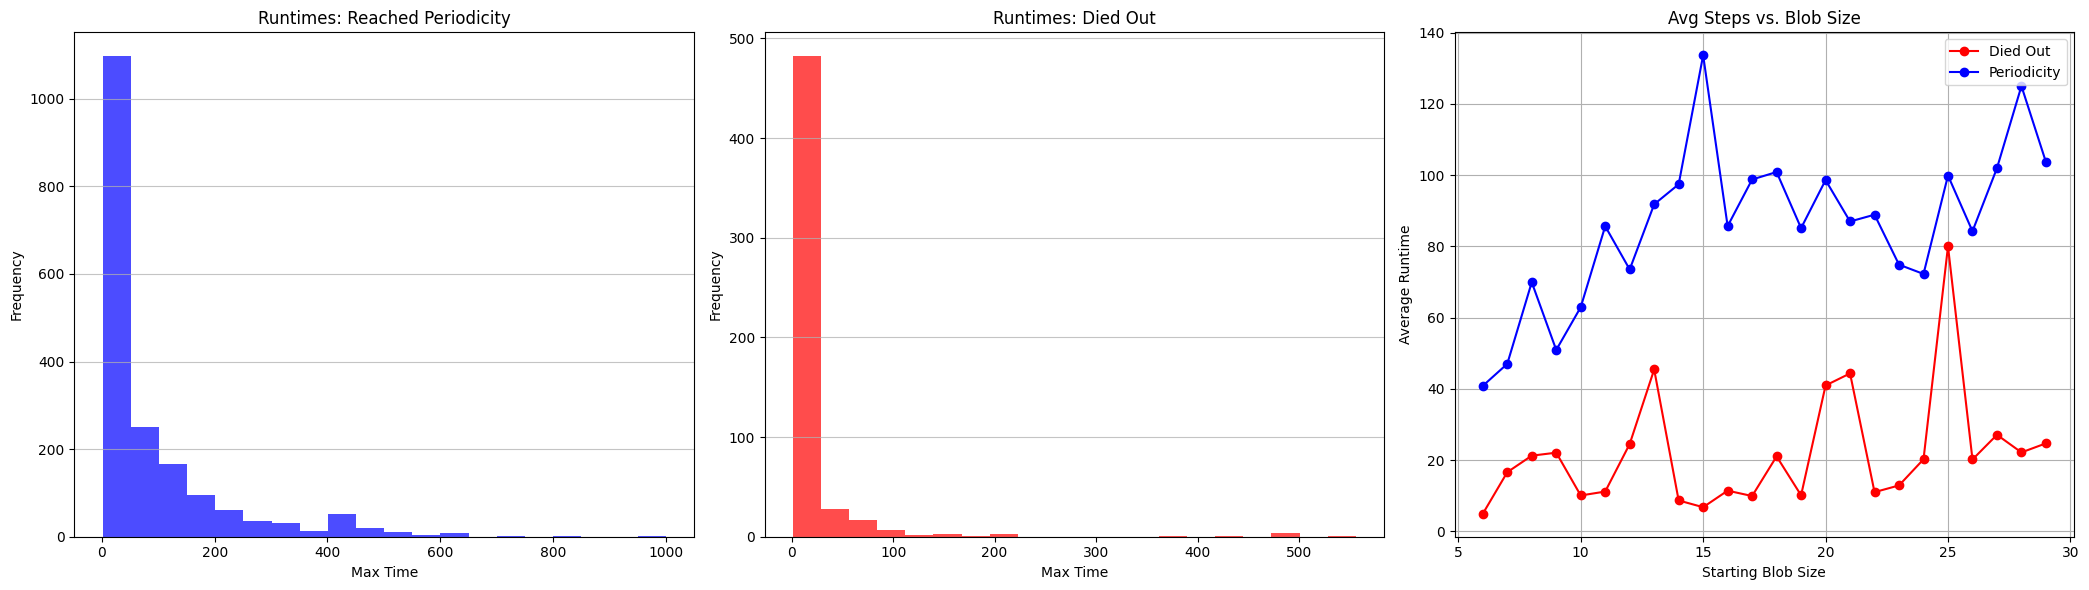

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(21, 6))

#Histogram: Reached periodicity
axs[0].hist([max_times_per_sim[i] for i in range(len(max_times_per_sim)) if not has_died1[i]], 
            bins=20, color='blue', alpha=0.7)
axs[0].set_title('Runtimes till reaching periodicity')
axs[0].set_xlabel('Max Time')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', alpha=0.75)

#Histogram: Died out
axs[1].hist([max_times_per_sim[i] for i in range(len(max_times_per_sim)) if has_died1[i]], 
            bins=20, color='red', alpha=0.7)
axs[1].set_title('Runtimes till dying out')
axs[1].set_xlabel('Max Time')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', alpha=0.75)

#Combined line plot: Average runtime vs. blob size
axs[2].plot(x_unique_died, y_avg_died, marker='o', color='red', label='Died out')
axs[2].plot(x_unique_not_died, y_avg_not_died, marker='o', color='blue', label='Periodicity')
axs[2].set_title('Avg Steps vs. Blob Size')
axs[2].set_xlabel('Starting Blob Size')
axs[2].set_ylabel('Average Runtime')
axs[2].grid()
axs[2].legend()

plt.tight_layout()
plt.show()

## Analyze possible GoL impacts and redundancies

### Synergy and redundancy measures

#### Synergistic impacts - statistically when Dual Total Correlation is greater than Total Correlation, i.e. Oinfo is negative

In [5]:
kill_array = np.array([[1, 1, 1, 1],
                        [1, 1, 1, 0], 
                        [1, 1, 0, 1],
                        [1, 0, 1, 1]])
kill_target = np.array([0, 1, 1, 1])
n = 4
k1 = compute_synergyMMI(kill_array, kill_target, k=n-1, l=n)
k2 = compute_redundancyMMI(kill_array, kill_target, k=n-1, l=n)
k3 = compute_TC(kill_array, kill_target, k=n, l=n)
k4 = compute_DTC(kill_array, kill_target, k=n, l=n)
k5 = compute_oinfo(kill_array, kill_target, k=n, l=n)
print(f"SynergyMMI: {k1},\nRedundancyMMI: {k2},\nTC: {k3},\nDTC: {k4},\nOinfo: {k5}")

SynergyMMI: [0.         0.         0.         0.49999997 0.        ],
RedundancyMMI: [7.11857240e-09 7.11857240e-09 7.11857240e-09 1.22556224e-01
 7.11857240e-09],
TC: 1.245112419128418,
DTC: 2.0,
Oinfo: -0.754887580871582


In [6]:
birth_array = np.array([[1, 1, 1], 
                        [1, 1, 0], 
                        [1, 0, 1],
                        [0, 1, 1]])
birth_target = np.array([1, 0, 0, 0])
n = 3

b1 = compute_synergyMMI(birth_array, birth_target, k=n, l=n)
b2 = compute_redundancyMMI(birth_array, birth_target, k=n, l=n)
b3 = compute_TC(birth_array, birth_target, k=n, l=n)
b4 = compute_DTC(birth_array, birth_target, k=n, l=n)
b5 = compute_oinfo(birth_array, birth_target, k=n, l=n)
print(f"SynergyMMI: {b1},\nRedundancyMMI: {b2},\nTC: {b3},\nDTC: {b4},\nOinfo: {b5}")

SynergyMMI: 0.4999999701976776,
RedundancyMMI: 0.12255622446537018,
TC: 1.245112419128418,
DTC: 2.000000238418579,
Oinfo: -0.754887580871582


In [7]:
no_birth_array = np.array([[1,1,1,1],
                        [0,1,1,1],
                        [1,0,1,1],
                        [1,1,0,1],
                        [1,1,1,0]])
no_birth_target = np.array([0, 1, 1, 1, 1]) #add other rows
n = 4
nb1 = compute_synergyMMI(no_birth_array, no_birth_target, k=n, l=n)
nb2 = compute_redundancyMMI(no_birth_array, no_birth_target, k=n, l=n)
nb3 = compute_TC(no_birth_array, no_birth_target, k=n, l=n)
nb4 = compute_DTC(no_birth_array, no_birth_target, k=n, l=n)
nb5 = compute_oinfo(no_birth_array, no_birth_target, k=n, l=n)
print(f"SynergyMMI: {nb1},\nRedundancyMMI: {nb2},\nTC: {nb3},\nDTC: {nb4},\nOinfo: {nb5}")

SynergyMMI: 0.3999998867511749,
RedundancyMMI: 0.07290555536746979,
TC: 1.2877119779586792,
DTC: 2.321927785873413,
Oinfo: -1.0342159271240234


In [8]:
live_nonactivekill_array = np.array([[1, 1, 1, 1],
                        [1, 1, 1, 0], 
                        [1, 1, 0, 1],
                        [1, 0, 1, 1]])
live_nonactivekill_target = np.array([0, 1, 1, 1])
n = 4
lnac1 = compute_synergyMMI(live_nonactivekill_array, live_nonactivekill_target, k=n-1, l=n)
lnac2 = compute_redundancyMMI(live_nonactivekill_array, live_nonactivekill_target, k=n-1, l=n)
lnac3 = compute_TC(live_nonactivekill_array, live_nonactivekill_target, k=n, l=n)
lnac4 = compute_DTC(live_nonactivekill_array, live_nonactivekill_target, k=n, l=n)
lnac5 = compute_oinfo(live_nonactivekill_array, live_nonactivekill_target, k=n, l=n)
print(f"SynergyMMI: {lnac1},\nRedundancyMMI: {lnac2},\nTC: {lnac3},\nDTC: {lnac4},\nOinfo: {lnac5}")

SynergyMMI: [0.         0.         0.         0.49999997 0.        ],
RedundancyMMI: [7.11857240e-09 7.11857240e-09 7.11857240e-09 1.22556224e-01
 7.11857240e-09],
TC: 1.245112419128418,
DTC: 2.0,
Oinfo: -0.754887580871582


#### Redundancy (lack of impact) - when DTC is less than TC, i.e. Oinfo is positive

In [9]:
redundancy_kill_array = np.array([[1, 1, 1, 1, 1],
                                  [1, 1, 1, 1, 0],
                                  [1, 1, 1, 0, 1], 
                                  [1, 1, 0, 1, 1],
                                  [1, 0, 1, 1, 1],
                                  [0, 1, 1, 1, 0], #instance added only for comparison, otherwise all y values are 1
                                  ])
redundancy_kill_target = np.array([0, 0, 0, 0, 0, 1])
n = 5 #n = 4
rk1 = compute_synergyMMI(redundancy_kill_array, redundancy_kill_target, k=n, l=n)
rk2 = compute_redundancyMMI(redundancy_kill_array, redundancy_kill_target, k=n, l=n)
rk3 = compute_TC(redundancy_kill_array, redundancy_kill_target, k=n, l=n)
rk4 = compute_DTC(redundancy_kill_array, redundancy_kill_target, k=n, l=n)
rk5 = compute_oinfo(redundancy_kill_array, redundancy_kill_target, k=n, l=n)
print(f"SynergyMMI: {rk1},\nRedundancyMMI: {rk2},\nTC: {rk3},\nDTC: {rk4},\nOinfo: {rk5}")

SynergyMMI: 0.0,
RedundancyMMI: 0.04841551184654236,
TC: 1.5834450721740723,
DTC: 1.2516286373138428,
Oinfo: 0.3318157196044922


In [10]:
redundancy_live = np.array([[1,1,1,1], #would fit better to do only [1, 1, 1], [1, 1, 0], [1, 0, 1], [0, 1, 1] but then target is constantly 1
                            [1,1,1,0],
                        [0,1,1, 0],
                        [1,1,0, 0],
                        [1,0,1, 0],
                        ])
redundancy_live_target = np.array([0, 1, 1, 1, 1]) #need to come up with a better way to do this, only 1s lead to 0.0
n = 4 #n = 3
rl1 = compute_synergyMMI(redundancy_live, redundancy_live_target, k=n, l=n)
rl2 = compute_redundancyMMI(redundancy_live, redundancy_live_target, k=n, l=n)
rl3 = compute_TC(redundancy_live, redundancy_live_target, k=n, l=n)
rl4 = compute_DTC(redundancy_live, redundancy_live_target, k=n, l=n)
rl5 = compute_oinfo(redundancy_live, redundancy_live_target, k=n, l=n)
print(f"SynergyMMI: {rl1},\nRedundancyMMI: {rl2},\nTC: {rl3},\nDTC: {rl4},\nOinfo: {rl5}")

SynergyMMI: -1.1920928955078125e-07,
RedundancyMMI: 0.07290555536746979,
TC: 1.2877119779586792,
DTC: 1.1219288110733032,
Oinfo: 0.16578292846679688


### Nonactive impacts

TODO

### Plots

TC: total correlation, associated with redundancy; high -> high strength of collective constraints

DTC: low -> high synergy

RSI: redundancy synergy index

RedundancyMMI, SynergyMMI

In [11]:
birth_hoi = compute_hoi_enc(birth_array, birth_target, k = 3, l = 3)
print(birth_hoi)

kill_hoi = (compute_hoi_enc(kill_array, kill_target, k = 4, l = 4))
print(kill_hoi)

live_nonactivekill_hoi = (compute_hoi_enc(live_nonactivekill_array, live_nonactivekill_target, k = 4, l = 4))
print(live_nonactivekill_hoi)

no_birth_hoi = (compute_hoi_enc(no_birth_array, no_birth_target, k = 4, l = 4))
print(no_birth_hoi)

redundancy_kill_hoi = (compute_hoi_enc(redundancy_kill_array, redundancy_kill_target, k = 5, l = 5))
print(redundancy_kill_hoi)

redundancy_live_hoi = (compute_hoi_enc(redundancy_live, redundancy_live_target, k = 4, l = 4))
print(redundancy_live_hoi)


-0.68872166
-0.68872166
-0.68872166
-0.8780718
0.31668854
0.32192707


1) e.g. 1 figure, 6 points, MMIs as axes, colored point if redundancy case
2) 2x3 figures: the 5 separate values (SynergyMMI, RedundancyMMI, TC, DTC, GradientOinfo)

In [12]:
types = ['kill', 'birth', 'no_birth', 'live & nonactive kill', 'redundancy kill', 'redundancy live']
values = [
    [k1[3], k2[3], k3, k4, kill_hoi],     #kill
    [b1, b2, b3, b4, birth_hoi],           #birth
    [nb1, nb2, nb3, nb4, no_birth_hoi],      #no_birth
    [lnac1[3], lnac2[3], lnac3, lnac4, live_nonactivekill_hoi], #live_nonactivekill
    [rk1, rk2, rk3, rk4, redundancy_kill_hoi],      #redundancy_kill
    [rl1, rl2, rl3, rl4, redundancy_live_hoi]       #redundancy_live
]
x_vals = [float(v[1]) for v in values]
y_vals = [float(v[0]) for v in values]

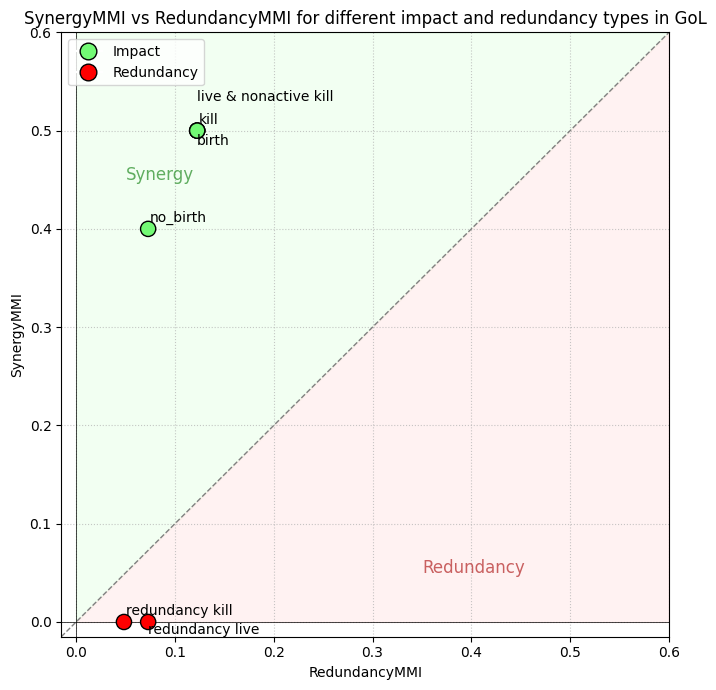

In [13]:
x_vals = [float(v[1]) for v in values]
y_vals = [float(v[0]) for v in values]
types = ['kill', 'birth', 'no_birth', 'live & nonactive kill', 'redundancy kill', 'redundancy live']
colors = ['#73fa75'] * 4 + ['#ff0000'] * 2
plt.figure(figsize=(7, 7))

#Shade y > x (synergy) and x > y (redundancy)
lims = [0, 0.6]
plt.fill_between(lims, lims, lims[1], color='#e6ffe6', alpha=0.5, label='Synergy (y > x)')
plt.fill_between(lims, lims[0], lims, color='#ffe6e6', alpha=0.5, label='Redundancy (x > y)')

scatter = plt.scatter(x_vals, y_vals, c=colors, s=120, edgecolor='black', zorder=3)

for i, label in enumerate(types):
    if i == 1:
        plt.annotate(label, (x_vals[i], y_vals[i] - 0.015), textcoords="data", ha='left', fontsize=10)
    elif i == 3:
        plt.annotate(label, (x_vals[i], y_vals[i] + 0.03), textcoords="data", ha='left', fontsize=10)
    elif i == 5:
        plt.annotate(label, (x_vals[i], y_vals[i] - 0.012), textcoords="data", ha='left', fontsize=10)
    else:
        plt.annotate(label, (x_vals[i]-0.005, y_vals[i]), textcoords="offset points", xytext=(5,5), ha='left', fontsize=10)

plt.xlabel('RedundancyMMI')
plt.ylabel('SynergyMMI')
plt.title('SynergyMMI vs RedundancyMMI for different impact and redundancy types in GoL')
plt.xlim(-0.015, 0.6)
plt.ylim(-0.015, 0.6)
plt.axline((0, 0), slope=1, color='gray', linestyle='dashed', linewidth=1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

plt.text(0.05, 0.45, 'Synergy', color='#228B22', fontsize=12, alpha=0.7)
plt.text(0.35, 0.05, 'Redundancy', color='#B22222', fontsize=12, alpha=0.7)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Impact', markerfacecolor='#73fa75', markersize=12, markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', label='Redundancy', markerfacecolor='#ff0000', markersize=12, markeredgecolor='black')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/GoL_impacts_MMI_Synergy_Redundancy.png', dpi=300, bbox_inches='tight')
plt.show()

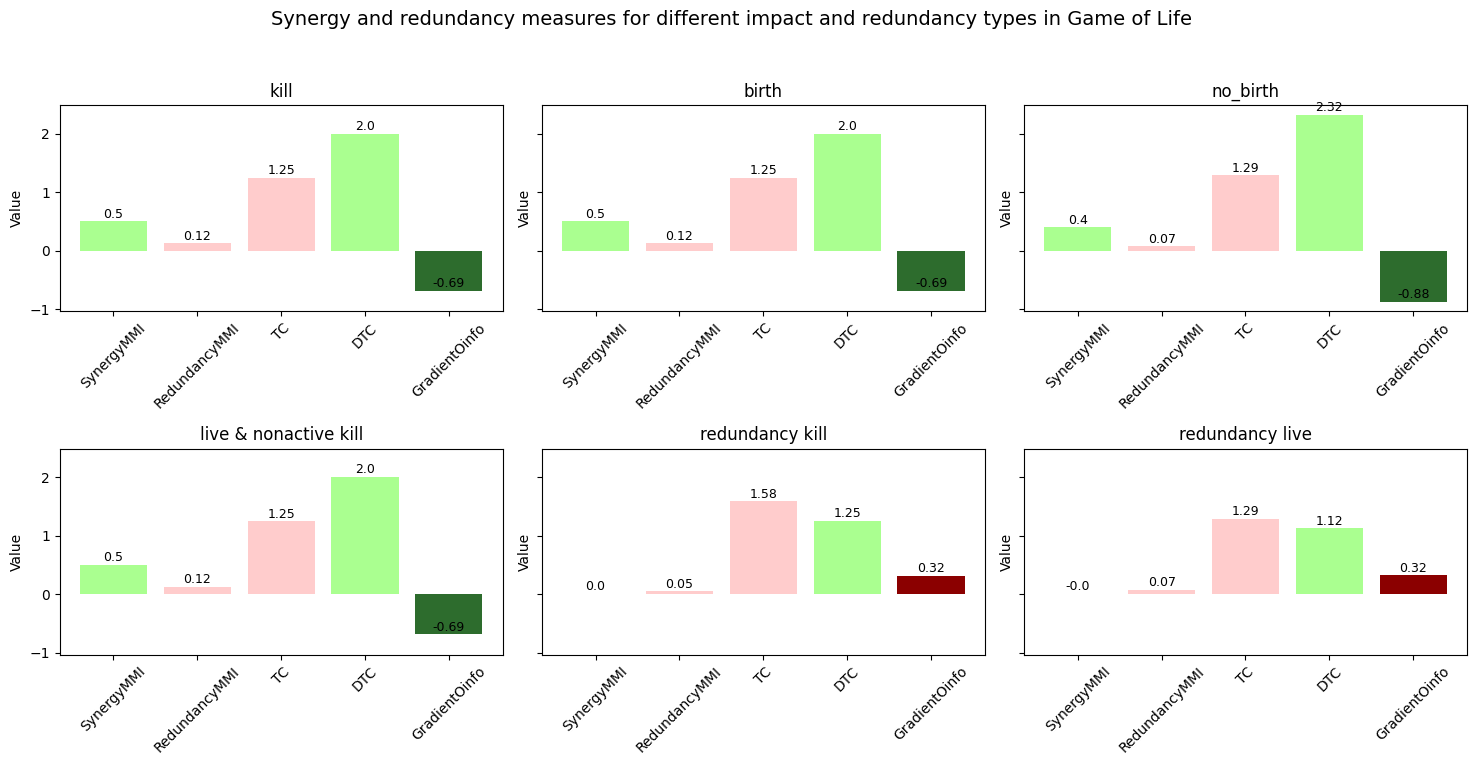

In [14]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['SynergyMMI', 'RedundancyMMI', 'TC', 'DTC', 'GradientOinfo']

bar_colors = [
    "#aaff90",   # SynergyMMI - light green
    '#ffcccc',   # RedundancyMMI - light red
    '#ffcccc',   # TC - light red
    '#aaff90',   # DTC - light green
    # Oinfo: first 4 dark green, last 2 dark red (handled per subplot)
]

column_texts = ['Synergy', 'Redundancy', 'Redundancy', 'Synergy', 'Oinfo']
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    oinfo_color = "#2D6C2D" if i < 4 else '#8B0000'
    colors = bar_colors[:] + [oinfo_color]
    bars = ax.bar(labels, [float(v) for v in values[i]], color=colors)
    ax.set_title(types[i])
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylabel('Value')
    for j, bar in enumerate(bars):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(float(values[i][j]),2),
                ha='center', va='bottom', fontsize=9, color='black', rotation=0)

fig.suptitle('Synergy and redundancy measures for different impact and redundancy types in Game of Life', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('plots/GoL_impacts_Synergy_Redundancy_measures.png', dpi=300, bbox_inches='tight')
plt.show()

## Self-organized structures

### Glider

In [ ]:
g = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]])
glider = Grid(g, width=15, height=15)
sim_glider = Model(glider, dynamics_func=game_of_life,)
sim_glider.simulation(steps=10, store_impact=True, impact_function=game_of_life_impact, active_only=False)

for i in range(4):
    entities = glider.get_time_slice("t_" + str(i))
    ratio = impact_group_ratio(sim_glider.impact["t_"+str(i)], entities)
    print("t_" + str(i) + " ratio: ", ratio)

for i in range(4):
    entities = glider.get_time_slice("t_" + str(i))
    ratio = impact_group_ratio(sim_glider.impact["t_"+str(i)], entities)
    print("t_" + str(i) + " ratio: ", ratio)

group1 = {(0, 1), (1, 2), (2, 0),(2, 1),(2, 2) }
plot_impact_group_ratio_over_time(sim_glider, group1, timestep_names= (0, 7), return_counts=False)

In [ ]:
entities_list = [glider.get_time_slice(t) for t in ["t_0"]]
plot_grids(entities_list, cols = 4, xlims=(0, 14), ylims=(0, 14), widths=4, heights=4, centers=True,
          cmaps =plt.cm.Oranges)

### Random initial grid(s)

In [16]:
n=37
grids1_n = (Grid(grids_dicts1[n], width=width, height=height))
grids2_n = (Grid(grids_dicts2[n], width=width, height=height))
grids3_n = (Grid(grids_dicts3[n], width=width, height=height))

sim1_n = Model(grids1_n, dynamics_func=game_of_life,)
sim1_n.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)
sim2_n = Model(grids2_n, dynamics_func=game_of_life,)
sim2_n.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)
sim3_n = Model(grids3_n, dynamics_func=game_of_life,)
sim3_n.simulate_till_periodicity(store_impact=True, impact_function=game_of_life_impact)

In [ ]:
still_life_dict = {(2, 2): 1, (2, 3): 1, (3, 2): 1, (3, 3): 1}
still_life_grid = Grid(still_life_dict, width=4, height=4)


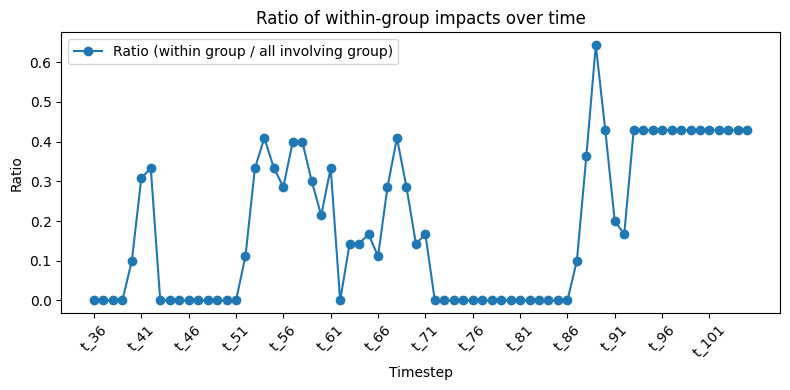

In [ ]:
group1 = {(18, 12), (18, 11), (17, 11), (17, 12),}
plot_impact_group_ratio_over_time(sim1_n, group1, timestep_names= (35, 105), return_counts=False)

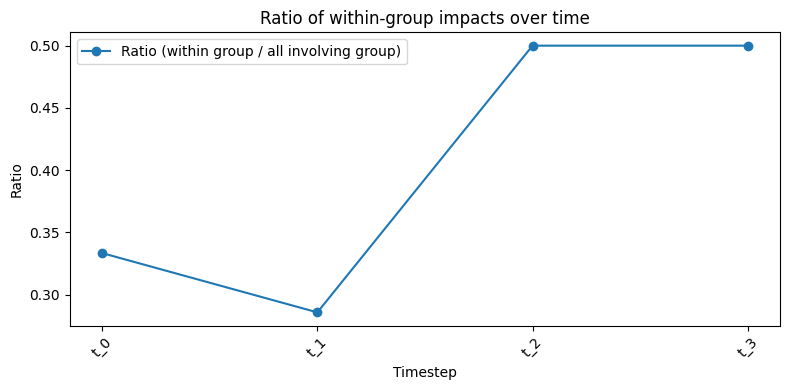

In [18]:
group2 = {(5, 5): 1,
 (5, 6): 1,
 (5, 7): 1,
 (5, 8): 1,
 (6, 7): 1,}
plot_impact_group_ratio_over_time(sim2_n, group2, return_counts=False)

## Next tasks

## Analysis of the 8 cells around a target cell 

All 512 possible combinations

In [19]:
def dec_to_bin(x, binary_length=9):
    return np.array([int(b) for b in format(x, f'0{binary_length}b')])

def bin_to_dec(bin, binary_length=9):
    return sum([pow(2,binary_length-j-1)*i for j,i in enumerate(bin)])

nodes = [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
states_all = []
impacts_all = []
categories = {}

for i in range(512):
    binary_vals = dec_to_bin(i)
    initial_arr = np.zeros((3, 3))
    for j in range(len(nodes)):
        initial_arr[nodes[j]] = binary_vals[j]
    grid = Grid(initial_arr, width=3, height=3)
    sim = Model(grid, dynamics_func=game_of_life,)
    sim.simulation(steps=1, store_impact=True, impact_function=game_of_life_impact)
    states = sim.structure.get_time_slice(key_name="t_1", only_nonzero=False)
    states_all.append(states)
    impacts_all.append(sim.impact)
    
    around = (binary_vals).copy()
    around[4] = 0
    s = np.sum(around)
    if s not in categories.keys():
        categories[s] = []
    categories[s].append((binary_vals,states[(1,1)], sim.impact)) #TODO

In [20]:
time_arrays = {}
y_values = {}
for n in range(9):
    instances = len(categories[n])
    time_array = np.zeros((instances, 9))
    ys = np.zeros(instances)
    for j,instance in enumerate(categories[n]):
        for k in range(9):
            time_array[j][k] = instance[0][k]
        ys[j] = instance[1]
    time_arrays[n] = time_array
    y_values[n] = ys

3)  Group theory: 3.1 check gliders in and out impact, and other self-ref machines
4) take many generated self-ref

Connect it with impact? e.g. impact can cover synergy, opposite can cover redundancy possibly? Only select impacts going to the target cell

## Other analysis